initialize_NLP() was modified from dev version to allow for kwargs...

In [2]:
using NLOptControl
using Plots
using Polynomials
using FastGaussQuadrature
using Parameters

# initialize basic problem definition
ps, nlp = initialize_NLP(numStates=2,numControls=2,Ni=2,Nck=[3, 3]);

####################################
# perform analytical calcualtions -> for plots
####################################
@unpack t0, tf = ps
t0 = Float64(0); tf = Float64(10);
@pack ps = t0, tf
t = Array(linspace(t0,tf,100));
α₁ =  -0.3; α₂ = 3; α₃ = -8; α₄ =  7;

γ = Poly([α₁,α₂,α₁]); #TODO check on that imported binding warning
y = polyval(γ,t);

# evaluate the integral
∫γ = polyint(γ);
Y = polyval(∫γ,t[end]) - polyval(∫γ,t[1]);
C = Y - polyval(∫γ,t[end]); # constant of integration
∫y = polyval(∫γ,t) + C;

# evaluate the derivative
dγ = polyder(γ);
dy = polyval(dγ,t);

##TEMP## -->to get fake optimization data
@unpack Nck, Ni, t0, tf = ps
taus_and_weights = [gaussradau(Nck[int]) for int in 1:Ni];
τ = [taus_and_weights[int][1] for int in 1:Ni];
ω = [taus_and_weights[int][2] for int in 1:Ni];
di, tm, t_data, ωₛ=create_intervals(t0,tf,Ni,Nck,τ,ω);
@pack ps = τ, ω
@unpack decisionVector, lengthControlVector, lengthStateVector, numStates, stateIdx = nlp
fake_control_data = zeros(lengthControlVector,);

if length(fake_control_data)!=lengthControlVector
  error(string("\n",
                "-------------------------------------", "\n",
                "There is an error with the indecies!!", "\n",
                "-------------------------------------", "\n",
                "The following variables should be equal:", "\n",
                "length(fake_control_data) = ",length(fake_control_data),"\n",
                "lengthControlVector = ",lengthControlVector,"\n"
                )
        )
end

# each row contains all of the data for an interval
fake_state = [[polyval(γ,t_data[int]); zeros(Float64,length(t_data[int]),)] for int in 1:Ni ];
fake_state_data = zeros(lengthStateVector,);
for int in 1:Ni # turn into vector
  fake_state_data[stateIdx[int][1]:stateIdx[int][2]] = fake_state[int];
end

if length(fake_state_data)!=lengthStateVector
  error(string("\n",
                "-------------------------------------", "\n",
                "There is an error with the indecies!!", "\n",
                "-------------------------------------", "\n",
                "The following variables should be equal:", "\n",
                "length(fake_state_data) = ",length(fake_state_data),"\n",
                "lengthStateVector = ",lengthStateVector,"\n"
                )
        )
end
decisionVector=[fake_state_data[:];fake_control_data;t0;tf]; # for now looking at no controls
@pack  nlp = decisionVector

##TEMP## -->to get fake optimization data

function nlp2ocp(decisionVector::Array{Float64,1},nlp::NLP_data,ps::PS_data)
    @unpack t0, tf, stateMatrix, controlMatrix, Ni = ps
    @unpack stateIdx, controlIdx, timeStartIdx, timeStopIdx, lengthDecVector = nlp

    if length(decisionVector)!=lengthDecVector
      error(string("\n",
                    "-------------------------------------", "\n",
                    "There is an error with the indecies!!", "\n",
                    "-------------------------------------", "\n",
                    "The following variables should be equal:", "\n",
                    "length(decisionVector) = ",length(decisionVector),"\n",
                    "lengthDecVector = ",lengthDecVector,"\n"
                    )
            )
    end
    # update parameters
    t0 = decisionVector[timeStartIdx];
    tf = decisionVector[timeStopIdx];

    stateMatrix  = [decisionVector[stateIdx[int][1]:stateIdx[int][2]] for int in 1:Ni];
    controlMatrix = [decisionVector[controlIdx[int][1]:controlIdx[int][2]] for int in 1:Ni];

    @pack ps = t0, tf, stateMatrix, controlMatrix
end

nlp2ocp(decisionVector,nlp,ps);

@unpack_PS_data ps
@unpack_NLP_data nlp
print(nlp,"\n","\n")
print(ps)


NLOptControl.NLP_data
  numStates: 2
  numControls: 2
  numStatePoints: [4,4]
  numControlPoints: [3,3]
  lengthStateVector: 16
  lengthControlVector: 12
  lengthDecVector: 30
  timeStartIdx: 29
  timeStopIdx: 30
  stateIdx: Tuple{Int64,Int64}[(1,8),(9,16)]
  controlIdx: Tuple{Int64,Int64}[(17,22),(23,28)]
  stateIdx_all: Tuple{Int64,Int64}[(1,4),(5,8),(9,12),(13,16)]
  controlIdx_all: Tuple{Int64,Int64}[(17,19),(20,22),(23,25),(26,28)]
  stateIdx_st: Tuple{Int64,Int64}[(1,4),(9,12),(5,8),(13,16)]
  controlIdx_ctr: Tuple{Int64,Int64}[(17,19),(23,25),(20,22),(26,28)]
  decisionVector: [-0.3,4.08031,7.01969,7.2,0.0,0.0,0.0,0.0,7.2,6.25454,1.84546,-0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0]

NLOptControl.PS_data
  Nck: [3,3]
  Ni: 2
  τ: Array{Float64,1}[[-1.0,-0.289898,0.689898],[-1.0,-0.289898,0.689898]]
  ω: Array{Float64,1}[[0.222222,1.02497,0.752806],[0.222222,1.02497,0.752806]]
  t0: 0.0
  tf: 10.0
  DMatrix: Array{Float64,2}[
[-2.5 3.76599 -2.7659

In [3]:
@unpack stateIdx_st, controlIdx_ctr = nlp

# approximate the integral
ζ = [zeros(Float64,Nck[int],) for int in 1:Ni]; approx_int = Float64(0); idx=1;
for st in 1:numStates
    for int in 1:Ni
        print(int,"\n")
        print(st,"\n")
        print(ωₛ[int],"\n")              
        print(decisionVector[stateIdx_st[idx][1]:stateIdx_st[idx][2]-1],"\n")

        ζ[int] =  cumsum(ωₛ[int].*decisionVector[stateIdx_st[idx][1]:stateIdx_st[idx][2]-1],1) #TODO save this!
        approx_int = approx_int + ζ[int][end];
        idx=idx+1;
    end
end

1
1
[0.555556,2.56243,1.88202]
[-0.3,4.08031,7.01969]
2
1
[0.555556,2.56243,1.88202]
[7.2,6.25454,1.84546]
1
2
[0.555556,2.56243,1.88202]
[0.0,0.0,0.0]
2
2
[0.555556,2.56243,1.88202]
[0.0,0.0,0.0]


In [11]:
ζ

2-element Array{Array{Float64,1},1}:
 [0.0,0.0,0.0]
 [0.0,0.0,0.0]

In [8]:
approx_int

47.0


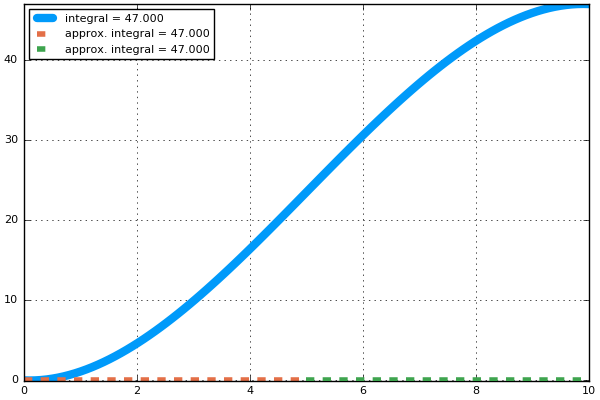

In [10]:

ip=plot(0,leg=:false)
plot!(t,∫y,label=@sprintf("integral = %0.3f",∫y[end]),w=6)
plot!(t_data,ζ,label=@sprintf("approx. integral = %0.3f",approx_int),line=(4,:dash))


In [42]:
# approximate the derivative --> needed in defect constraints
D = [zeros((Nck[int]+1),(Nck[int]+1)) for int in 1:Ni]
for int in 1:Ni
    D[int] = poldif(t_data[int], 1) # append +1 onto τ
end
DMatrix = [zeros((Nck[int]),(Nck[int]+1)) for int in 1:Ni];
DM = [zeros((Nck[int]),(Nck[int])) for int in 1:Ni];
IMatrix = DM;
for int in 1:Ni
    DMatrix[int] = D[int][1:end-1,:];   # turn into a [Nck]X[Nck+1] sized matrix
    DM[int] = D[int][1:end-1,:1:end-1]; # turn into a [Nck]X[Nck] sized matrix
    IMatrix[int] = inv(DM[int]);        # integration matrix
end
#TODO add matrices bACK TO PARAMETERS

In [83]:
# approximate the derivative --> needed in defect constraints
dζ = zeros(Float64, numStates, Nck[int], Ni); idx = 1;
for st in 1:numStates
    for int in 1:Ni
        dζ[st,1:Nck[int],int] = DMatrix[int]*decisionVector[stateIdx_st[idx][1]:stateIdx_st[idx][2]];
        idx=idx+1
    end
end

In [84]:
int=1
idx=1
st = 1
DMatrix[int]*decisionVector[stateIdx_st[idx][1]:stateIdx_st[idx][2]]



3-element Array{Float64,1}:
 3.0     
 1.93485 
 0.465153

In [70]:
s1=1;int=1
dζ[st][1:Nck[int]]
dζ = [zeros(Float64, numStates, Ni, Nck[int]) for int in 1:Ni]
dζ[1]

2×2×3 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0
 0.0  0.0

[:, :, 2] =
 0.0  0.0
 0.0  0.0

[:, :, 3] =
 0.0  0.0
 0.0  0.0

In [49]:
idx=1
int = 1
DMatrix[int]*decisionVector[stateIdx_st[idx][1]:stateIdx_st[idx][2]]

3-element Array{Float64,1}:
 3.0     
 1.93485 
 0.465153

In [50]:
idx=2
int = 2
DMatrix[int]*decisionVector[stateIdx_st[idx][1]:stateIdx_st[idx][2]]

3-element Array{Float64,1}:
 -2.22045e-15
 -1.06515    
 -2.53485    

In [48]:
int = 1
st = 1
dζ[st][1:Nck[int]]

3-element Array{Float64,1}:
 -2.22045e-15
 -1.06515    
 -2.53485    

In [36]:
idx=1
decisionVector[stateIdx_st[idx][1]:stateIdx_st[idx][2]]

4-element Array{Float64,1}:
 -0.3    
  4.08031
  7.01969
  7.2    


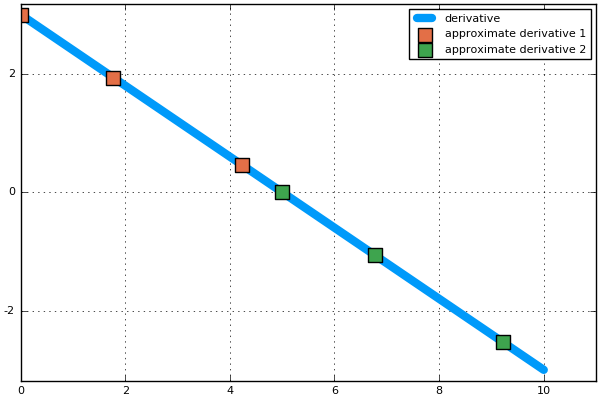

In [86]:
dp=plot(0,leg=:false)
plot!(t,dy,label="derivative",w=6)
for st in 1:1
    for int in 1:Ni
        scatter!(t_data[int][1:end-1],dζ[st,1:Nck[int],int],markersize =10,markershape = :rect,label=string("approximate derivative ",int))
      #tF[int] = t_data[end,int];
      #yF[int] = dζ[end,int];
    end
end
#scatter!(tF,yF,markersize = 10,markershape = :star8,label=string("end points"))
xlims!(t0,tf*1.1)

In [39]:
dζ[int][1:Nck[int]]

LoadError: UndefVarError: int not defined

In [33]:
dζ[1][1:Nck[1]]

3-element Array{Float64,1}:
 -2.22045e-15
 -1.06515    
 -2.53485    

In [30]:
dζ[1][1:Nck[2]]

3-element Array{Float64,1}:
 -2.22045e-15
 -1.06515    
 -2.53485    

In [21]:
DMatrix[1]

3×4 Array{Float64,2}:
 -1.0         1.50639   -1.10639    0.6     
 -0.210639   -0.155051   0.713568  -0.347878
  0.0506395  -0.233568  -0.644949   0.827878

In [37]:
DMatrix[2]

3×4 Array{Float64,2}:
 -1.0         1.50639   -1.10639    0.6     
 -0.210639   -0.155051   0.713568  -0.347878
  0.0506395  -0.233568  -0.644949   0.827878

In [9]:
τ

2-element Array{Array{Float64,1},1}:
 [-1.0,-0.289898,0.689898]
 [-1.0,-0.289898,0.689898]

In [ ]:
#################
# post processing
#################
tF = zeros(Float64,Ni); yF =  zeros(Float64,Ni);
fp=plot(0,leg=:false);
plot!(t,y,label=string(γ),w=6)
for int in 1:Ni
 # scatter!(t_data[1:end-1,int],P[1:end-1,int],markersize =10,markershape = :rect,label=string("collocation points for mesh interval ",int))
  tF[int] = t_data[end,int];
  #yF[int] = P[end,int];
end
scatter!(tF,yF,markersize = 10,markershape = :star8,label=string("end points"))
xlims!(t0,tf*1.1)

dp=plot(0,leg=:false)
plot!(t,dy,label="derivative",w=6)
for int in 1:Ni
  scatter!(t_data[1:end-1,int],dζ[1:end-1,int],markersize =10,markershape = :rect,label=string("approximate derivative ",int))
  tF[int] = t_data[end,int];
  yF[int] = dζ[end,int];
end
scatter!(tF,yF,markersize = 10,markershape = :star8,label=string("end points"))
xlims!(t0,tf*1.1)

ip=plot(0,leg=:false)
plot!(t,∫y,label=@sprintf("integral = %0.3f",∫y[end]),w=6)
plot!(t_data,ζ,label=@sprintf("approx. integral = %0.3f",approx_int),line=(4,:dash))

plot(fp,ip,dp,layout=(3,1))